## Imports

In [20]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

## Mounting Google Drive

In [21]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Loading the dataset

In [22]:
train_path = "/content/drive/MyDrive/Colab Notebooks/maestro-midi/train_128.pickle"
test_path = "/content/drive/MyDrive/Colab Notebooks/maestro-midi/test_128.pickle"

In [23]:
with open(train_path, 'rb') as train_pickle:
    train_data = pickle.load(train_pickle)

In [24]:
with open(test_path, 'rb') as test_pickle:
    test_data =  pickle.load(test_pickle)

In [25]:
print("Length of train data: ", len(train_data))
print("Length of test data: ", len(test_data))

Length of train data:  214858
Length of test data:  26984


When we take whole training data the free google collab session is crashing because of high RAM usage. To solve this problem for now, we are going to take less no. of samples

In [26]:
train_data = train_data[:70000]

In [27]:
print("Length of train data: ", len(train_data))

Length of train data:  70000


Lets plot sample data

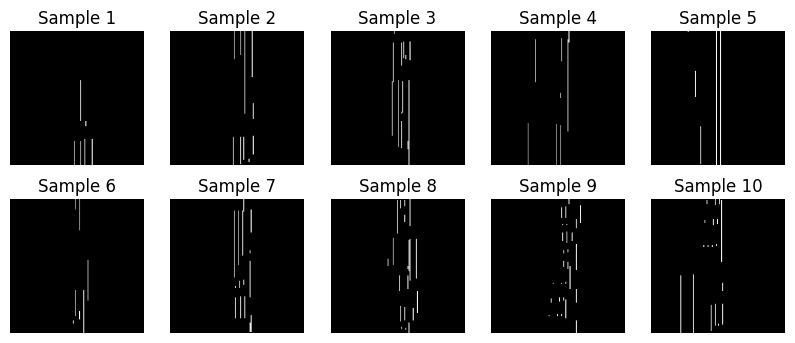

In [28]:
import matplotlib.pyplot as plt

# Take the first 10 images from the list
selected_images = train_data[:10]

# Create a 2x5 grid for plotting 10 images
rows, cols = 2, 5

# Set up the subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 4))

# Iterate through the selected images and plot them
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        axes[i, j].imshow(selected_images[index], cmap='gray')  # Assuming grayscale images
        axes[i, j].axis('off')  # Turn off axis labels
        axes[i, j].set_title(f'Sample {index + 1}')

plt.show()


In [29]:
train_data = 127 - train_data

In [30]:
test_data = 127 - test_data

## Building the architecture

### Sampling Layer

In [31]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [32]:
mean = np.array([[0.1,1.2,0.2,0.8]], dtype=np.float32)
standard_deviation = np.array([[0.2,0.5,0.8,1.3]], dtype=np.float32)
z = Sampler()(mean, standard_deviation)

In [33]:
print(z.numpy())
print(z.shape)

[[-0.39526027 -0.83871055 -0.09738375  0.15309429]]
(1, 4)


### Encoder

In [34]:
latent_dim = 256

encoder_inputs = keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [35]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 64, 64, 32)           320       ['input_3[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 32, 32, 64)           18496     ['conv2d_4[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 16, 16, 128)          73856     ['conv2d_5[0][0]']            
                                                                                            

### Decoder

In [36]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [37]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_3 (Dense)             (None, 32768)             8421376   
                                                                 
 reshape_1 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 32, 32, 128)       147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 64, 64, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 128, 128, 32)      1846

### Architecture

In [38]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        data = data / 127
        data = np.expand_dims(data, -1)
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_training_loss": self.total_loss_tracker.result(),
            "training_reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "training_kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        data = data / 127
        data = np.expand_dims(data, -1)
        z_mean, z_log_var = self.encoder(data)
        z = self.sampler(z_mean, z_log_var)
        reconstruction = self.decoder(z)

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction),
                axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "total_testing_loss": self.total_loss_tracker.result(),
            "testing_reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "testing_kl_loss": self.kl_loss_tracker.result(),
        }

## Training Model

In [39]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(train_data, epochs=50, batch_size=64)

Epoch 1/50


1094/1094 [==============================] - 147s 125ms/step - total_training_loss: 2101212.0243 - training_reconstruction_loss: 1991.7545 - training_kl_loss: 2099216.8402
Epoch 2/50
1094/1094 [==============================] - 134s 123ms/step - total_training_loss: 535.3166 - training_reconstruction_loss: 533.9520 - training_kl_loss: 1.3648
Epoch 3/50
1094/1094 [==============================] - 134s 122ms/step - total_training_loss: 498.5679 - training_reconstruction_loss: 497.1734 - training_kl_loss: 1.3944
Epoch 4/50
1094/1094 [==============================] - 135s 123ms/step - total_training_loss: 482.8051 - training_reconstruction_loss: 481.1268 - training_kl_loss: 1.6782
Epoch 5/50
1094/1094 [==============================] - 134s 123ms/step - total_training_loss: 460.0207 - training_reconstruction_loss: 457.9729 - training_kl_loss: 2.0479
Epoch 6/50
1094/1094 [==============================] - 134s 122ms/step - total_training_loss: 398.4732 - training_reconstruction_loss: 395.

In [40]:
vae.save_weights("/content/drive/MyDrive/Colab Notebooks/maestro-midi/checkpoints/mycheckpoints")

### Model Evaluation

In [41]:
results = vae.evaluate(test_data)

844/844 [==============================] - 33s 38ms/step - total_testing_loss: 361.5133 - testing_reconstruction_loss: 358.5608 - testing_kl_loss: 2.9527


In [42]:
print("Total Testing Loss: ", results[2])
print("Testing Reconstruction Loss: ", results[1])
print("Testing KL Loss: ", results[0])

Total Testing Loss:  361.08953857421875
Testing Reconstruction Loss:  358.146728515625
Testing KL Loss:  2.9423129558563232


In [43]:
vae2 = VAE(encoder, decoder)
vae2.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae2.load_weights("/content/drive/MyDrive/Colab Notebooks/maestro-midi/checkpoints/mycheckpoints")

In [44]:
results = vae2.evaluate(test_data)

844/844 [==============================] - 30s 36ms/step - total_testing_loss: 361.4807 - testing_reconstruction_loss: 358.5279 - testing_kl_loss: 2.9527


In [45]:
print("Total Testing Loss: ", results[2])
print("Testing Reconstruction Loss: ", results[1])
print("Testing KL Loss: ", results[0])

Total Testing Loss:  361.0836486816406
Testing Reconstruction Loss:  358.1402282714844
Testing KL Loss:  2.9423129558563232


## Prediction Time

In [46]:
test_data = test_data[:1000] / 127
print(test_data)

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 ...

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]


In [47]:
print(test_data.shape)


(1000, 128, 128)


In [48]:
z_mean, z_log_var = vae2.encoder.predict(test_data)
z = vae2.sampler(z_mean, z_log_var)
predictions = vae2.decoder.predict(z)

32/32 [==============================] - 0s 12ms/step


In [49]:
predictions.shape

(1000, 128, 128, 1)

In [70]:
preds =  np.squeeze(predictions, axis=-1)
preds = preds.astype(np.float32) * 127 - 127

print(preds.shape)

(1000, 128, 128)


In [71]:
preds[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [51]:
!pip install pypianoroll

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 7.7 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592284 sha256=1e7980ed0e40c0f5283c1bb78ad81255bd28bbd0cd310ebe3b6e71b108f3091b
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty-midi


In [52]:
import pypianoroll as ppr

In [53]:
def array_to_pianoroll(arr, chunk_size=128):
    """
    Convert a 2D array to a pypianoroll.Multitrack object.
    """

    # Create a Multitrack object with one track
    multitrack = ppr.Multitrack(resolution = 8)
    track = ppr.BinaryTrack(pianoroll=arr)
    multitrack.tracks.append(track)

    return multitrack

#### single_sample

In [76]:
pred1 = preds[40]
ppr.write("vae_single.mid", array_to_pianoroll(pred1))

In [55]:
!pip install music21

In [56]:
from music21 import converter

def play_midi_file(midi_filename):
    # Load the MIDI file
    midi_stream = converter.parse(midi_filename)

    # Play the MIDI stream
    midi_stream.show('midi')

In [77]:
midi_filename = "./vae_single.mid"
play_midi_file(midi_filename)

#### concatenating samples

In [58]:
p2 = np.concatenate((preds[:, :, :], preds[:, :, :]), axis=1)

p2 = preds.reshape((-1, 128))
p2.shape

(128000, 128)

In [78]:
ppr.write("vae_whole.mid", array_to_pianoroll(p2))

#### random generation

In [80]:
z =  tf.keras.backend.random_normal(shape=(1, latent_dim))
x_decoded = vae2.decoder.predict(z)
p3 =  np.squeeze(x_decoded[0], axis=-1)
p_final = p3.astype(np.float32) * 127 - 127
print(p_final.shape)

1/1 [==============================] - 0s 27ms/step
(128, 128)


In [81]:
ppr.write("vae_random.mid", array_to_pianoroll(p_final))

In [82]:
midi_filename = "./vae_random.mid"
play_midi_file(midi_filename)